# COVID-19 India Timeseries: A Visualization

This kernel provides a visualization of COVID-19 timeseries data in states of India.

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [2]:
# Read data
corona_data = pd.read_csv("..\data\covid19-india-statewise-timeseries.csv",index_col=0, parse_dates=True, dayfirst=True)

# Remove first three days as not much infomation there
#corona_data=corona_data[3:]
corona_data=corona_data.last('30D')

# Fill all blank values to 0
corona_data = corona_data.fillna(0);

# Convert all numeric columns to int32
corona_data[['Total Confirmed Cases', 'Cured/Discharged/Migrated','Death']] = corona_data[['Total Confirmed Cases', 'Cured/Discharged/Migrated','Death']].astype('int32')

# Active cases = Confirmed cases - (Cured/Dicharged cases + Deaths)
active_cases = corona_data['Total Confirmed Cases'] - corona_data['Cured/Discharged/Migrated'] - corona_data['Death']

# Add Active cases column to the original data
corona_data.insert(2, 'Active Cases', active_cases)

# Aggregate the state data datewise to get the national numbers
india_data = corona_data.groupby('Date').sum()['Active Cases'].to_frame(name = 'Active Cases')

# Get the data for last reported date
full_latest = corona_data.last('1D')

# Sort descending
full_latest = full_latest.sort_values(by=['Active Cases'], ascending=False)

# Get the data for the top 10 states from the lates reported data
top_ten = full_latest[:10]

# Get the list of top 10 states as per the latest data
state_list_top10 = top_ten['State'].unique()

# Get all historical data for top 10 state
corona_data_top10 = corona_data[corona_data['State'].isin(top_ten['State'].tolist())] 

#maha_data = corona_data.loc[corona_data['State'] == 'Maharashtra']
maha_data = corona_data.sort_values(by=['State','Date','Total Confirmed Cases'], ascending=True)
maha_data['Change'] = maha_data.groupby('State')['Total Confirmed Cases'].diff(1)
maha_data = maha_data.sort_values(by=['State','Date','Total Confirmed Cases'], ascending=False)
maha_data.loc[maha_data['State'] == 'Maharashtra']

,State,Total Confirmed Cases,Active Cases,Cured/Discharged/Migrated,Death,Change
Date,,,,,,
2020-04-28,Maharashtra,8590,6939,1282,369,522.0
2020-04-27,Maharashtra,8068,6538,1188,342,440.0
2020-04-26,Maharashtra,7628,6229,1076,323,811.0
2020-04-25,Maharashtra,6817,5559,957,301,387.0
2020-04-24,Maharashtra,6430,5307,840,283,778.0
2020-04-23,Maharashtra,5652,4594,789,269,431.0
2020-04-22,Maharashtra,5221,4248,722,251,552.0
2020-04-21,Maharashtra,4669,3865,572,232,466.0
2020-04-20,Maharashtra,4203,3473,507,223,552.0


The table below summarizes the latest nationwide statistics for India on the last reported date.

In [3]:
summary_data = full_latest.groupby('Date')['Total Confirmed Cases', 'Active Cases', 'Cured/Discharged/Migrated', 'Death'].sum().reset_index()
summary_data['Date'] = summary_data['Date'].dt.strftime('%d %B %Y')
summary_data.style.format({"Total Confirmed Cases": "{:,.0f}", "Active Cases": "{:,.0f}", "Cured/Discharged/Migrated": "{:,.0f}", "Death": "{:,.0f}"})

styles = [
    dict(selector="th", props=[("font-size", "120%"),
                               ("text-align", "center"),
                              ("font-weight", "normal"),
                              ("color", "grey")]),
    dict(selector="td", props=[("font-size", "300%"),
                               ("text-align", "center"),
                              ("background-color", "white"),
                           ("color", "dodgerblue")]),
    #dict(selector=".row_heading, .blank", props=[("display", "none;")])
]

html = (summary_data.style.set_table_styles(styles))
html

,Date,Total Confirmed Cases,Active Cases,Cured/Discharged/Migrated,Death
0,28 April 2020,29834,21870,7027,937


Here's the gradient map for statewise cases on the latest reported data.

In [4]:
# latest aggregated data
full_latest_grouped = full_latest.groupby('State')['Total Confirmed Cases', 'Active Cases', 'Cured/Discharged/Migrated', 'Death'].sum().reset_index()

full_latest_grouped = full_latest_grouped.sort_values(by='Total Confirmed Cases', ascending=False)
full_latest_grouped = full_latest_grouped.reset_index(drop=True)
full_latest_grouped.style.background_gradient(cmap='mako_r')

,State,Total Confirmed Cases,Active Cases,Cured/Discharged/Migrated,Death
0,Maharashtra,8590,6939,1282,369
1,Gujarat,3548,2992,394,162
2,Delhi,3108,2177,877,54
3,Madhya Pradesh,2368,1894,361,113
4,Rajasthan,2262,1547,669,46
5,Uttar Pradesh,2043,1612,400,31
6,Tamil Nadu,1937,812,1101,24
7,Andhra Pradesh,1259,970,258,31
8,Telangana,1004,657,321,26
9,West Bengal,697,568,109,20


Here's the active cases trend in India for last 30 days. Eagerly waiting for the curve to "flatten"!!!

C:\Anaconda2\envs\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


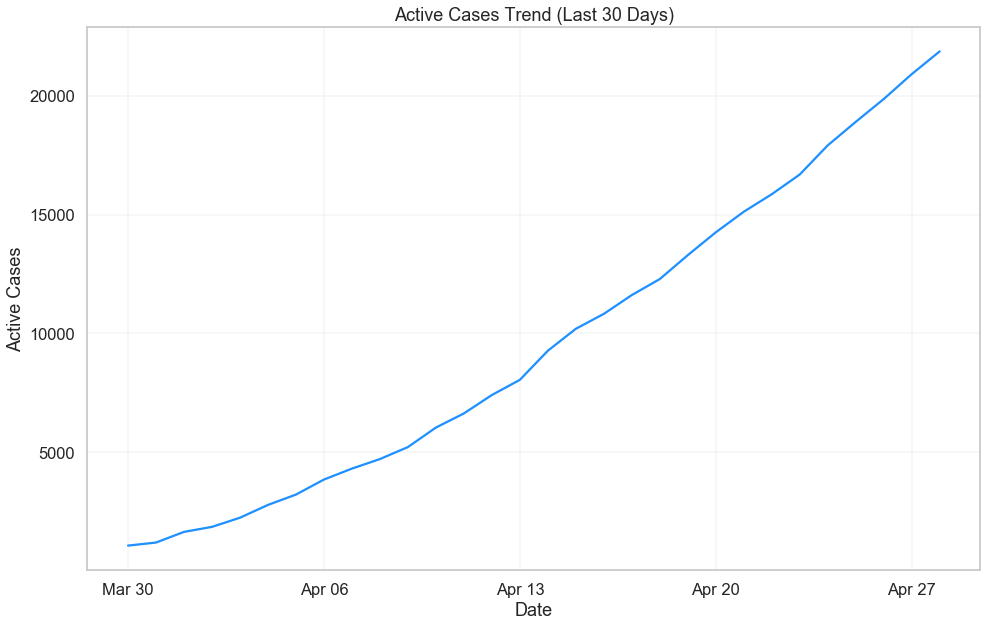

In [5]:
plt.figure(figsize=(16, 10))

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_context("talk", rc={"grid.linewidth": 0.3})
#palette = sns.color_palette("Blues", 1);
plot = sns.lineplot(x=india_data.index, y='Active Cases', legend=False, hue=None, color="dodgerblue",
                  data=india_data)

# Set x-axis major ticks to weekly interval, on Mondays
plot.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

plt.title('Active Cases Trend (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Active Cases')
plt.show()

The pie chart below shows the percentage of active cases in each state based on the data reported on the last day.

In [6]:
# Consilidate rest of the states apart from top 10 into a single entry called 'Others'
others_confirmed_sum = full_latest[10:]['Total Confirmed Cases'].sum()
others_active_sum = full_latest[10:]['Active Cases'].sum()

others_data = pd.DataFrame({'State':['Others'], 
                    'Total Confirmed Cases':others_confirmed_sum,  
                    'Active Cases':others_active_sum,
                    'Cured/Discharged/Migrated':0,
                    'Death':0}, index=[top_ten.index[0]]) 

# Add the 'Others' entry to top 10
top_ten_with_others = top_ten.append(others_data)

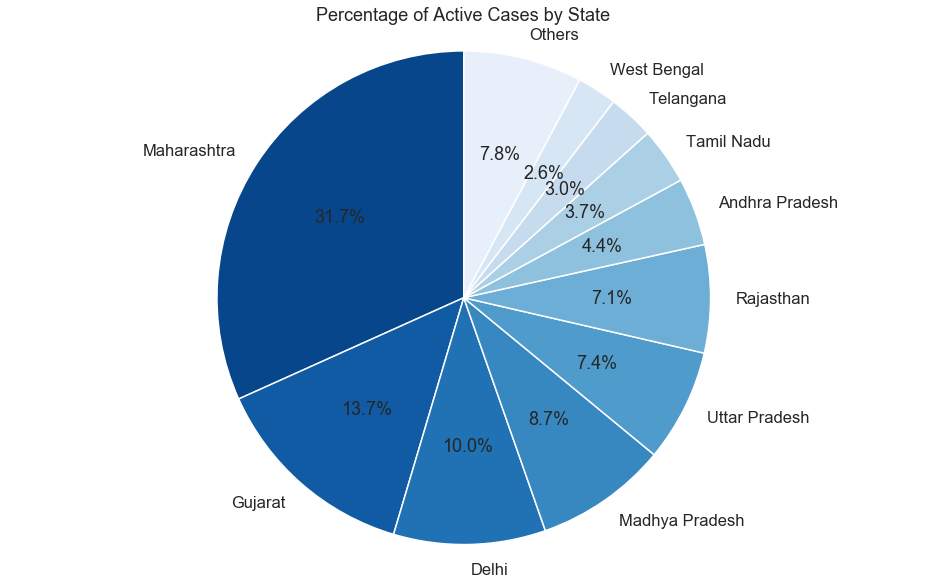

In [7]:
# Plot pie chart to see the percentage of active cases statewise
palette=sns.color_palette("Blues_r", n_colors=11)

# Plot
plt.figure(figsize=(16, 10))
plt.pie(top_ten_with_others['Active Cases'], labels=top_ten_with_others['State'], colors=palette,
autopct='%1.1f%%', shadow=False, startangle=90)

plt.title('Percentage of Active Cases by State')
plt.axis('equal')
plt.show()

Here's the comparitive active cases trend of the top 10 states in last 30 days.

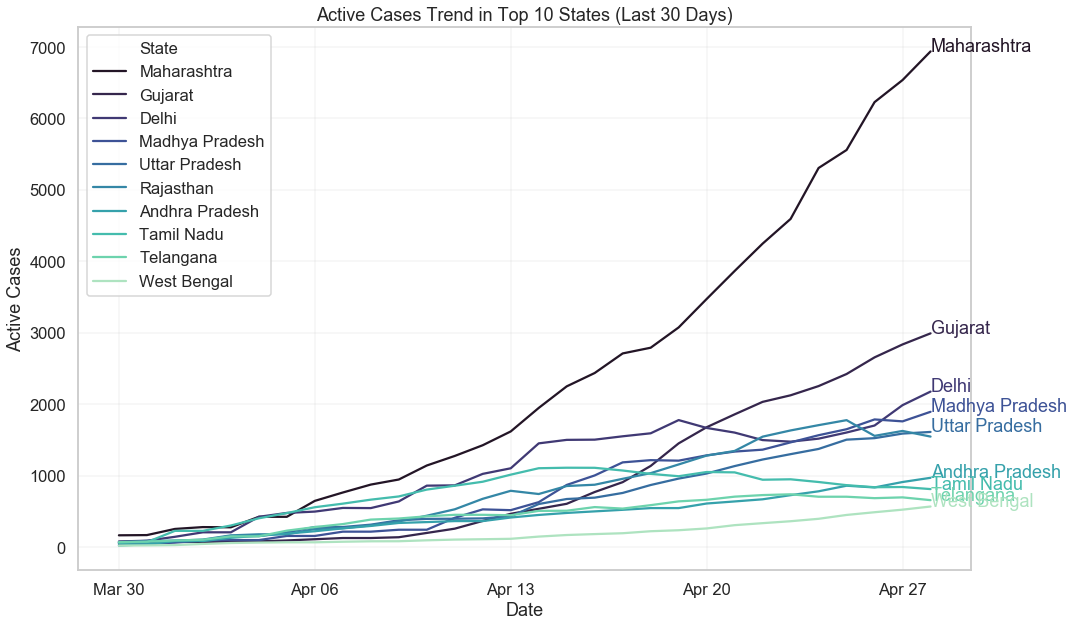

In [8]:
plt.figure(figsize=(16, 10))

palette=sns.color_palette("mako", 10)
sns.set_style("whitegrid")
sns.set_context("talk", rc={"grid.linewidth": 0.3})

plot = sns.lineplot(x=corona_data_top10.index, y="Active Cases", legend='brief',
                  hue="State", hue_order = state_list_top10, palette=palette, 
                  data=corona_data_top10)

# Set x-axis major ticks to weekly interval, on Mondays
plot.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

previous_y = 999999999999
x = full_latest['State'].index[0]
for i, state in enumerate(state_list_top10):
    y = full_latest[full_latest['State']==state]['Active Cases'][0]
    # Do not overlap annotations
    if ((previous_y - y) > 70):
        plot.annotate(state, xy=(x, y),color=palette[i])
    previous_y = y

plt.title('Active Cases Trend in Top 10 States (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Active Cases')
plt.show()

...and here's the active cases trend for all states that reported a case.

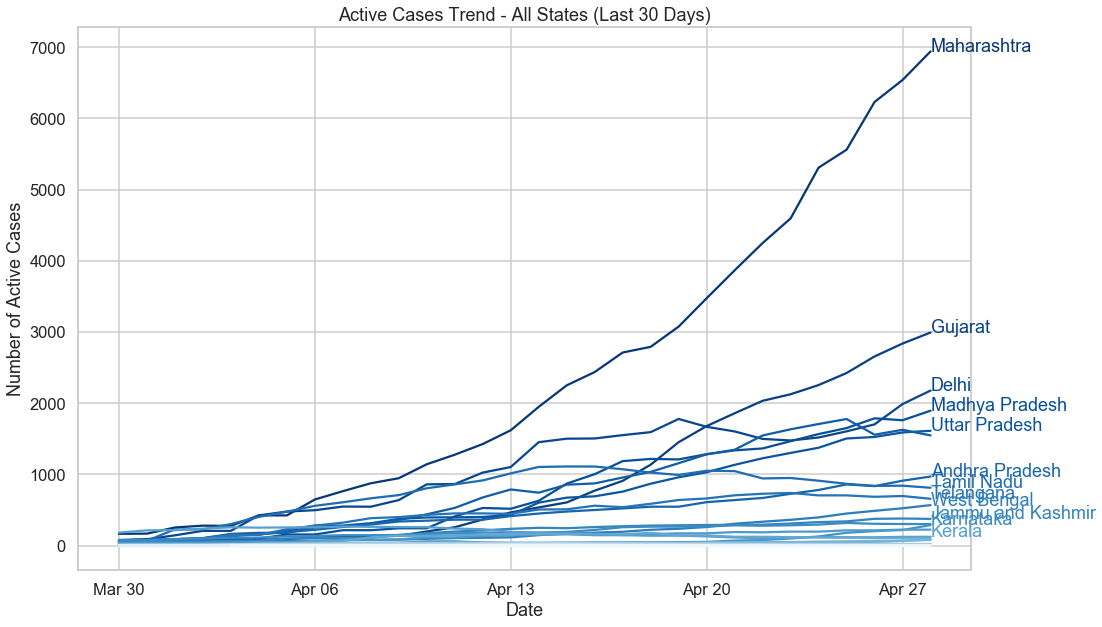

In [9]:
# Get sorted list of states by active cases from the master data. This list will be used as hue_order for linegraph
state_master_sorted = corona_data.groupby('State')['State','Active Cases'].last().sort_values(by='Active Cases', ascending=False)

plt.figure(figsize=(16, 10))

palette=sns.color_palette("Blues_r", corona_data['State'].nunique())
sns.set_context("talk")

plot = sns.lineplot(x=corona_data.index, y="Active Cases", legend=False,
                  hue="State", hue_order = state_master_sorted['State'], palette=palette, 
                  data=corona_data)

# Set x-axis major ticks to weekly interval, on Mondays
plot.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

previous_y = 999999999999
x = full_latest['State'].index[0]
for i, state in enumerate(state_master_sorted['State']):
    y = state_master_sorted.loc[state_master_sorted['State'] == state]['Active Cases'][0]
    # Do not overlap annotations
    if ((previous_y - y) > 70):
        plot.annotate(state, xy=(x, y),color=palette[i])
    previous_y = y

plt.title('Active Cases Trend - All States (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Number of Active Cases')
plt.show()